In [30]:
# script adapted from https://www.kaggle.com/kmader/create-a-mini-xray-dataset-standard


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from cv2 import imread, createCLAHE # read and equalize images
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm



In [31]:
# import the data
df = pd.read_csv('../data/sample_labels.csv')
image_path = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'data', 'images', '*.png'))}

print('Scans found:', len(image_path), ', Total Entries', df.shape[0])

df['path'] = df['Image Index'].map(image_path.get)

df['Patient Age'] = df['Patient Age'].map(lambda x: int(x[:-1]))

#cleaning up the columns
df.drop(['Follow-up #', 'OriginalImageWidth', 
         'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y'], axis=1, inplace=True)
                                     
df.sample(3)

Scans found: 5606 , Total Entries 5606


,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,path
3347,00016508_065.png,Emphysema|Nodule,16508,52,F,AP,../data/images/00016508_065.png
3110,00015355_000.png,No Finding,15355,72,M,PA,../data/images/00015355_000.png
1371,00007120_015.png,No Finding,7120,54,F,PA,../data/images/00007120_015.png


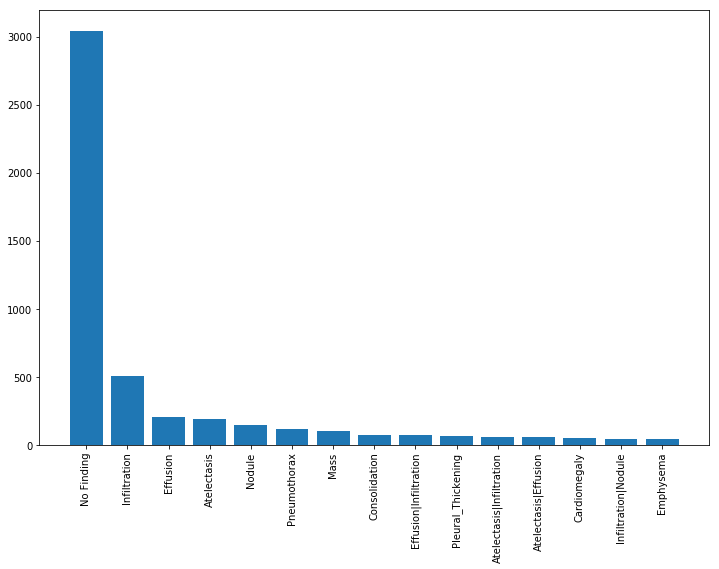

In [32]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [33]:
# changed all of the 'no finding' labels to blanks to then be removed furthe down the line for sample balancing
# choosing to leave those for the time being
# df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5147,00027415_025.png,Nodule,27415,23,M,AP,../data/images/00027415_025.png,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4532,00022611_005.png,Cardiomegaly|Consolidation|Effusion,22611,30,F,AP,../data/images/00022611_005.png,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1078,00005681_018.png,Emphysema|Pneumonia,5681,46,M,AP,../data/images/00005681_018.png,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
# keep at least 1000 cases

MIN_CASES = 50

all_labels = [c_label for c_label in all_labels if df[c_label].sum()>MIN_CASES]

print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 508), ('Cardiomegaly', 141), ('Consolidation', 226), ('Edema', 118), ('Effusion', 644), ('Emphysema', 127), ('Fibrosis', 84), ('Infiltration', 967), ('Mass', 284), ('No Finding', 3044), ('Nodule', 313), ('Pleural_Thickening', 176), ('Pneumonia', 62), ('Pneumothorax', 271)]


<div class="span5 alert alert-info">
below number will need to be adjusted to full data set
</div>

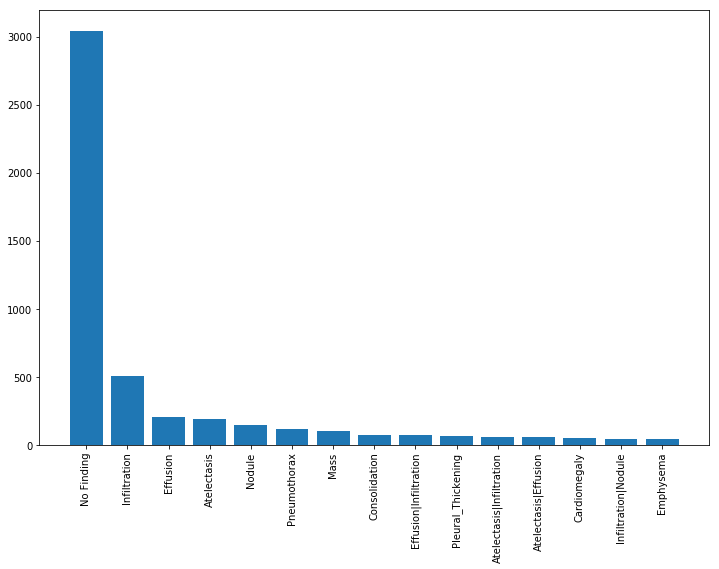

In [35]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection

# weight is 0.1 + number of findings

sample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
df = df.sample(5606, weights=sample_weights)


label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [36]:
'''# since we can't have everything make a nice subset
# weight is 0.1 + number of findings

sample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 1e-1
sample_weights /= sample_weights.sum()
df = df.sample(18000, weights=sample_weights)

label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)'''

"# since we can't have everything make a nice subset\n# weight is 0.1 + number of findings\n\nsample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 1e-1\nsample_weights /= sample_weights.sum()\ndf = df.sample(18000, weights=sample_weights)\n\nlabel_counts = df['Finding Labels'].value_counts()[:15]\nfig, ax1 = plt.subplots(1,1,figsize = (12, 8))\nax1.bar(np.arange(len(label_counts))+0.5, label_counts)\nax1.set_xticks(np.arange(len(label_counts))+0.5)\n_ = ax1.set_xticklabels(label_counts.index, rotation = 90)"

# Create an HDF5

In [37]:
import h5py
from tqdm import tqdm

def write_df_as_hdf(out_path,
                    out_df,
                    compression='gzip'):
    with h5py.File(out_path, 'w') as h:
        for k, arr_dict in tqdm(out_df.to_dict().items()):
            try:
                s_data = np.stack(arr_dict.values(), 0)
                try:
                    h.create_dataset(k, data=s_data, compression=
                    compression)
                except TypeError as e:
                    try:
                        h.create_dataset(k, data=s_data.astype(np.string_),
                                         compression=compression)
                    except TypeError as e2:
                        print('%s could not be added to hdf5, %s' % (
                            k, repr(e), repr(e2)))
            except ValueError as e:
                print('%s could not be created, %s' % (k, repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
                warn('Input shapes: {}'.format(all_shape))

In [38]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, 
                                   test_size = 0.20, 
                                   random_state = 2007,
                                   stratify = df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4484 validation 1122


In [39]:
write_df_as_hdf('chest_xray_train_data.h5', train_df)

# show what is inside
with h5py.File('chest_xray_train_data.h5', 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

100%|██████████| 22/22 [00:00<00:00, 87.46it/s]

Atelectasis (4484,) float64
Cardiomegaly (4484,) float64
Consolidation (4484,) float64
Edema (4484,) float64
Effusion (4484,) float64
Emphysema (4484,) float64
Fibrosis (4484,) float64
Finding Labels (4484,) |S84
Hernia (4484,) float64
Image Index (4484,) |S16
Infiltration (4484,) float64
Mass (4484,) float64
No Finding (4484,) float64
Nodule (4484,) float64
Patient Age (4484,) int64
Patient Gender (4484,) |S1
Patient ID (4484,) int64
Pleural_Thickening (4484,) float64
Pneumonia (4484,) float64
Pneumothorax (4484,) float64
View Position (4484,) |S2
path (4484,) |S31


In [40]:
write_df_as_hdf('chest_xray_valid_data.h5', valid_df)

# show what is inside
with h5py.File('chest_xray_valid_data.h5', 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

100%|██████████| 22/22 [00:00<00:00, 306.33it/s]


Atelectasis (1122,) float64
Cardiomegaly (1122,) float64
Consolidation (1122,) float64
Edema (1122,) float64
Effusion (1122,) float64
Emphysema (1122,) float64
Fibrosis (1122,) float64
Finding Labels (1122,) |S56
Hernia (1122,) float64
Image Index (1122,) |S16
Infiltration (1122,) float64
Mass (1122,) float64
No Finding (1122,) float64
Nodule (1122,) float64
Patient Age (1122,) int64
Patient Gender (1122,) |S1
Patient ID (1122,) int64
Pleural_Thickening (1122,) float64
Pneumonia (1122,) float64
Pneumothorax (1122,) float64
View Position (1122,) |S2
path (1122,) |S31


In [41]:
# write_df_as_hdf('chest_xray.h5', df)

# show what is inside
with h5py.File('chest_xray.h5', 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

In [42]:
from skimage.transform import resize

OUT_DIM = (128, 128)

def imread_and_normalize(im_path):
    clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    img_data = clahe_tool.apply(img_data)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    return np.expand_dims(n_img, -1)


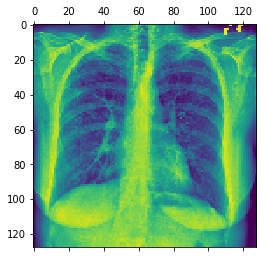

In [43]:
test_img_train = imread_and_normalize(train_df['path'].values[0])
plt.matshow(test_img_train[:,:,0])

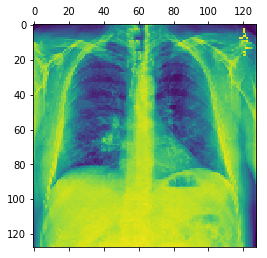

In [44]:
test_img_valid = imread_and_normalize(valid_df['path'].values[0])
plt.matshow(test_img_valid[:,:,0])

# Run time estimate

In [45]:
'''%%time
# time for 100 images
pre_read_tiles = np.stack(train_df.sample(100)['path'].map(imread_and_normalize).values,0)'''

"%%time\n# time for 100 images\npre_read_tiles = np.stack(train_df.sample(100)['path'].map(imread_and_normalize).values,0)"

In [46]:
'''# might as well show-em if we have em
from skimage.util.montage import montage2d
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
ax1.imshow(montage2d(pre_read_tiles[:,:,:,0]), cmap = 'bone')
fig.savefig('overview.png', dpi = 600)'''

"# might as well show-em if we have em\nfrom skimage.util.montage import montage2d\nfig, ax1 = plt.subplots(1,1, figsize = (12,12))\nax1.imshow(montage2d(pre_read_tiles[:,:,:,0]), cmap = 'bone')\nfig.savefig('overview.png', dpi = 600)"

whole array export

In [47]:
'''# preallocate output
out_image_arr = np.zeros((df.shape[0],)+OUT_DIM+(1,), dtype=np.uint8)
if False:
    # a difficult to compress array for size approximations
    out_image_arr = np.random.uniform(0, 255,
                                  size = (df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)'''

'# preallocate output\nout_image_arr = np.zeros((df.shape[0],)+OUT_DIM+(1,), dtype=np.uint8)\nif False:\n    # a difficult to compress array for size approximations\n    out_image_arr = np.random.uniform(0, 255,\n                                  size = (df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)'

In [48]:
'''for i, c_path in enumerate(tqdm(df['path'].values)):
    out_image_arr[i] = imread_and_normalize(c_path)'''

"for i, c_path in enumerate(tqdm(df['path'].values)):\n    out_image_arr[i] = imread_and_normalize(c_path)"

In [49]:
'''# append the array
with h5py.File('chest_xray.h5', 'a') as h5_data:
    h5_data.create_dataset('images', data = out_image_arr, compression = None) # compression takes too long
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)'''

"# append the array\nwith h5py.File('chest_xray.h5', 'a') as h5_data:\n    h5_data.create_dataset('images', data = out_image_arr, compression = None) # compression takes too long\n    for c_key in h5_data.keys():\n        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)"

Train

In [50]:
# preallocate output
out_image_arr_train = np.zeros((train_df.shape[0],)+OUT_DIM+(1,), dtype=np.uint8)
if False:
    # a difficult to compress array for size approximations
    out_image_arr_train = np.random.uniform(0, 255,
                                  size = (train_df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)

In [51]:
for i, c_path in enumerate(tqdm(train_df['path'].values)):
    out_image_arr_train[i] = imread_and_normalize(c_path)

100%|██████████| 4484/4484 [05:00<00:00, 14.93it/s]


In [52]:
# append the array
with h5py.File('chest_xray_train_data.h5', 'a') as h5_data:
    h5_data.create_dataset('images', data = out_image_arr_train, compression = None) # compression takes too long
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

Atelectasis (4484,) float64
Cardiomegaly (4484,) float64
Consolidation (4484,) float64
Edema (4484,) float64
Effusion (4484,) float64
Emphysema (4484,) float64
Fibrosis (4484,) float64
Finding Labels (4484,) |S84
Hernia (4484,) float64
Image Index (4484,) |S16
Infiltration (4484,) float64
Mass (4484,) float64
No Finding (4484,) float64
Nodule (4484,) float64
Patient Age (4484,) int64
Patient Gender (4484,) |S1
Patient ID (4484,) int64
Pleural_Thickening (4484,) float64
Pneumonia (4484,) float64
Pneumothorax (4484,) float64
View Position (4484,) |S2
images (4484, 128, 128, 1) uint8
path (4484,) |S31


Validation

In [53]:
# preallocate output
out_image_arr_valid = np.zeros((valid_df.shape[0],)+OUT_DIM+(1,), dtype=np.uint8)
if False:
    # a difficult to compress array for size approximations
    out_image_arr_valid = np.random.uniform(0, 255,
                                  size = (valid_df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)

In [54]:
for i, c_path in enumerate(tqdm(valid_df['path'].values)):
    out_image_arr_valid[i] = imread_and_normalize(c_path)

100%|██████████| 1122/1122 [01:16<00:00, 14.76it/s]


In [55]:
# append the array
with h5py.File('chest_xray_valid_data.h5', 'a') as h5_data:
    h5_data.create_dataset('images', data = out_image_arr_valid, compression = None) # compression takes too long
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

Atelectasis (1122,) float64
Cardiomegaly (1122,) float64
Consolidation (1122,) float64
Edema (1122,) float64
Effusion (1122,) float64
Emphysema (1122,) float64
Fibrosis (1122,) float64
Finding Labels (1122,) |S56
Hernia (1122,) float64
Image Index (1122,) |S16
Infiltration (1122,) float64
Mass (1122,) float64
No Finding (1122,) float64
Nodule (1122,) float64
Patient Age (1122,) int64
Patient Gender (1122,) |S1
Patient ID (1122,) int64
Pleural_Thickening (1122,) float64
Pneumonia (1122,) float64
Pneumothorax (1122,) float64
View Position (1122,) |S2
images (1122, 128, 128, 1) uint8
path (1122,) |S31


In [56]:
print('Train Output File-size %2.2fMB' % (os.path.getsize('chest_xray_train_data.h5')/1e6))
print('Validation Output File-size %2.2fMB' % (os.path.getsize('chest_xray_valid_data.h5')/1e6))

Train Output File-size 73.62MB
Validation Output File-size 18.46MB
